In [1]:
import mmdet
from mmcv import Config

D:\app\Anaconda3\envs\openmmlab\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
config = Config.fromfile("mask_rcnn_r50_coco.py")
print(config.pretty_text)

checkpoint_config = dict(interval=1)
log_config = dict(interval=24, hooks=[dict(type='TextLoggerHook')])
custom_hooks = [dict(type='NumClassCheckHook')]
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'mask_rcnn_r50_fpn_mstrain-poly_3x_coco_20210524_201154-21b550bb.pth'
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
auto_scale_lr = dict(enable=False, base_batch_size=16)
dataset_type = 'CocoDataset'
data_root = 'data/coco/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='LoadAnnotations',
        with_bbox=True,
        with_mask=True,
        poly2mask=False),
    dict(
        type='Resize',
        img_scale=[(1333, 640), (1333, 800)],
        multiscale_mode='range',
        keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.67

In [3]:
#!mim download mmdet --config faster_rcnn_r50_fpn_1x_coco --dest .

In [8]:
from mmdet.apis import init_detector, inference_detector,show_result_pyplot

config_file = 'result/mask_rcnn_r50_coco.py'
# 从 model zoo 下载 checkpoint 并放在 `checkpoints/` 文件下
# 网址为: http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = 'result/mask_rcnn_r50_coco_balloon_best.pth'
device = 'cuda:0'
# 初始化检测器
model = init_detector(config_file, checkpoint_file, device=device)
# 推理演示图像
inference_detector(model, 'test_balloon_2.jpg')

load checkpoint from local path: result/mask_rcnn_r50_coco_balloon_best.pth


([array([[6.04946655e+02, 1.80369461e+02, 7.66373535e+02, 3.20659332e+02,
          9.97512341e-01],
         [4.25054077e+02, 7.09173050e+01, 5.51327637e+02, 2.28988342e+02,
          9.97488022e-01],
         [5.24401672e+02, 8.94584503e+01, 6.65810120e+02, 2.40737213e+02,
          9.96822357e-01],
         [7.38245789e+02, 1.69881638e+02, 8.35548279e+02, 3.04662476e+02,
          9.95649636e-01],
         [6.58573547e+02, 5.35398750e+01, 8.04403931e+02, 1.92519333e+02,
          9.95313644e-01],
         [5.78668152e+02, 3.35645874e+02, 6.76894104e+02, 4.36184570e+02,
          9.89227533e-01],
         [4.84752472e+02, 2.04892853e+02, 6.15859436e+02, 3.17407257e+02,
          9.49752152e-01],
         [5.97331787e+02, 2.65212952e+02, 6.87705933e+02, 3.35507416e+02,
          6.30126894e-01],
         [5.46847839e+02, 4.34675074e+00, 6.89398621e+02, 1.09836235e+02,
          4.94991869e-01],
         [5.89505005e+02, 3.22610962e+02, 6.44394775e+02, 3.44609039e+02,
          6.15862

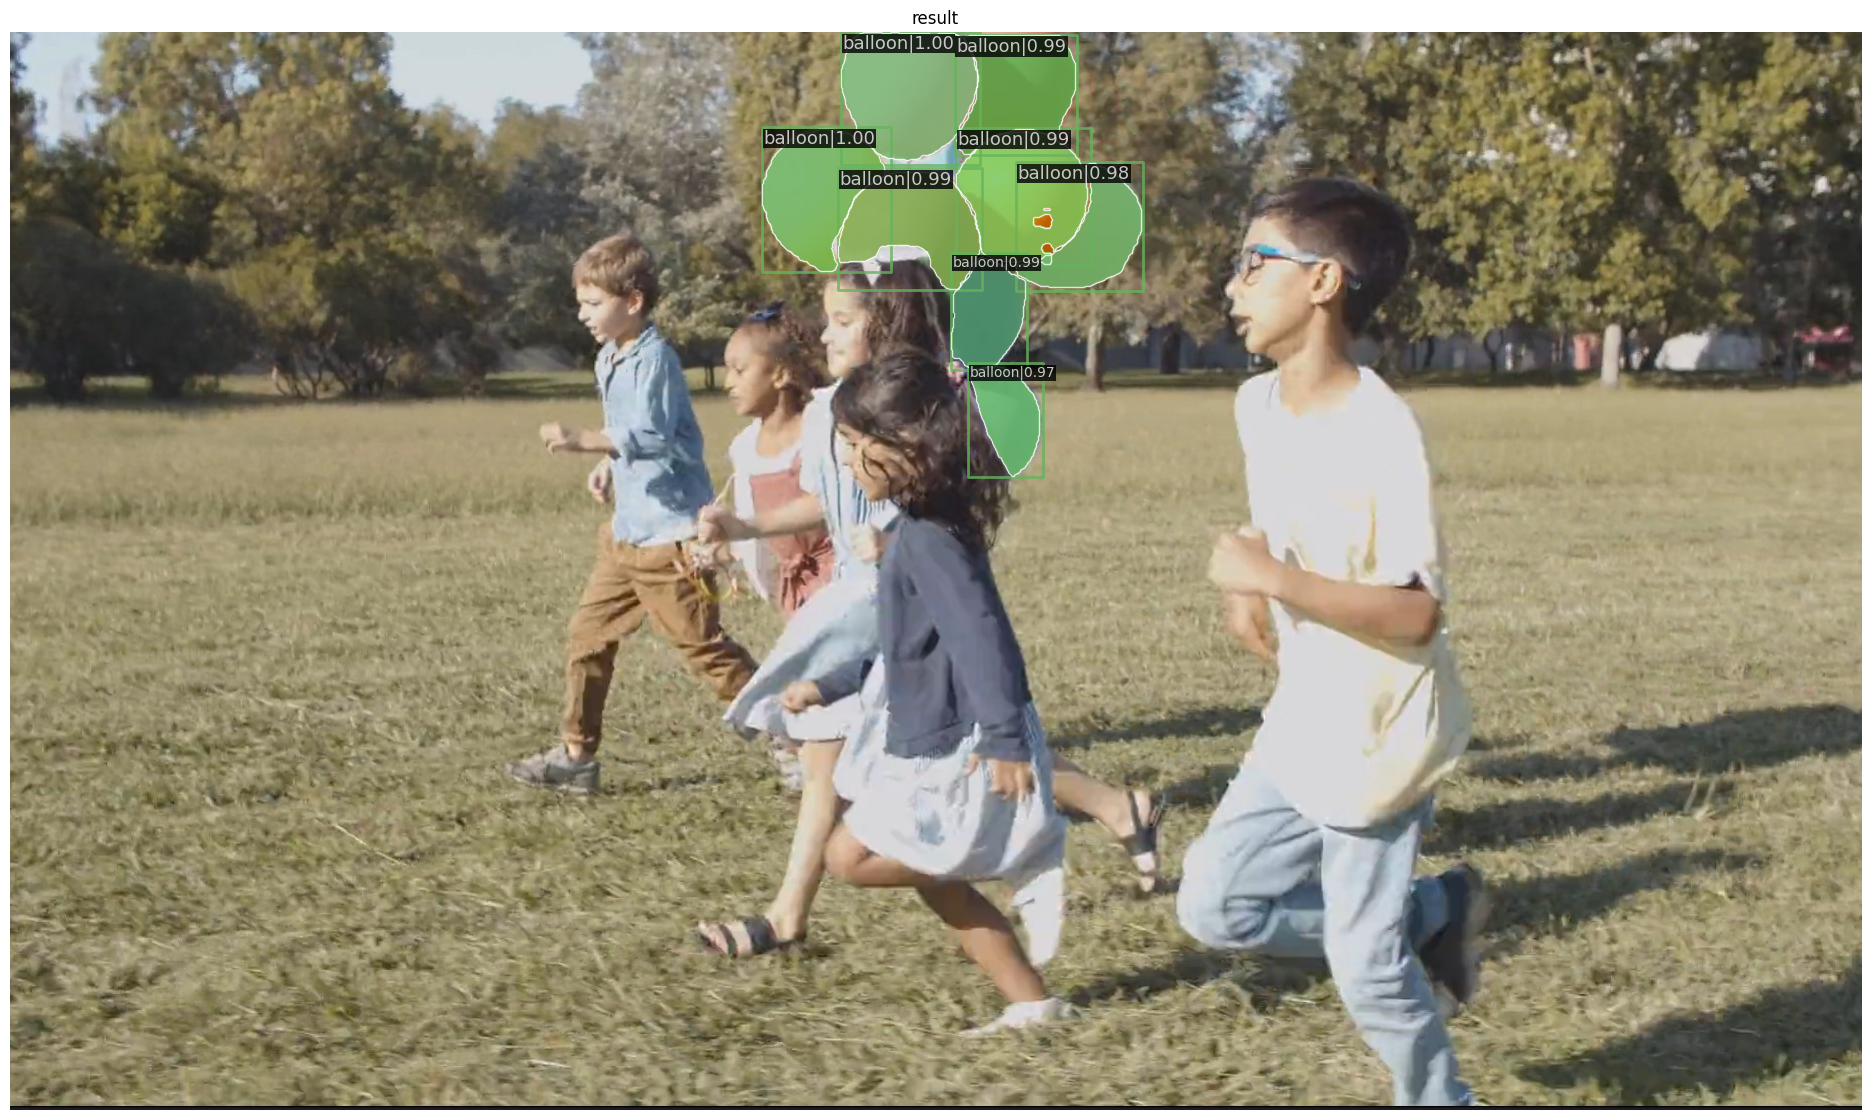

In [9]:
result=inference_detector(model, 'test_balloon.jpg')
show_result_pyplot(model,'test_balloon.jpg',result)


In [11]:
# 视频处理
import cv2
import mmcv
import numpy as np
import torch
from mmdet.apis import init_detector, inference_detector

In [12]:
video_reader = mmcv.VideoReader("test_video.mp4")
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(
    './color_splash.mp4', fourcc, video_reader.fps,
    (video_reader.width, video_reader.height))
device = 'cuda:0'
model = init_detector('result/mask_rcnn_r50_coco.py', './result/mask_rcnn_r50_coco_balloon_best.pth', device=device)

load checkpoint from local path: ./result/mask_rcnn_r50_coco_balloon_best.pth


In [13]:
# 参考 https://github.com/aso538/OpenMMLab_AI_camp_work/blob/main/basic_wor_2/color_splash.py
score_thr = 0.85
for frame in video_reader:
    result = inference_detector(model, frame)
    mask = None
    masks = result[1][0]
    for i in range(len(masks)):
        if result[0][0][i][-1] >= score_thr:
            if not mask is None:
                mask = mask | masks[i]
            else:
                mask = masks[i]

    # 获取各通道mask像素

    masked_b = frame[:, :, 0] * mask
    masked_g = frame[:, :, 1] * mask
    masked_r = frame[:, :, 2] * mask
    masked = np.concatenate([masked_b[:,:,None],masked_g[:,:,None],masked_r[:,:,None]],axis=2)

    # frame转灰度图

    un_mask = 1 - mask
    frame_b = frame[:, :, 0] * un_mask
    frame_g = frame[:, :, 1] * un_mask
    frame_r = frame[:, :, 2] * un_mask
    frame = np.concatenate([frame_b[:, :, None], frame_g[:, :, None], frame_r[:, :, None]], axis=2).astype(np.uint8)
    frame = mmcv.bgr2gray(frame, keepdim=True)
    frame = np.concatenate([frame, frame, frame], axis=2)
    # mask加到灰度图中

    frame += masked

    # frame = model.show_result(frame, result, score_thr=score_thr)
    video_writer.write(frame)

video_writer.release()
cv2.destroyAllWindows()

D:\app\Anaconda3\envs\openmmlab\lib\site-packages\mmdet\datasets\utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
